# Corner Plot with Best-Fit Overlay

Posterior samples from one run with best-fit markers from another overlaid.

In [65]:
import re
import json
import os

import numpy as np
from getdist import MCSamples, plots as gd_plots

## 1. Settings

In [66]:
RUN_POSTERIOR = "../results/withoutoffset_run_2026-01-29_14-04/"
RUN_BESTFIT = "../results/cfwithoutoffset_run_2026-02-01_14-46/"

PARAMS_TO_PLOT = [
    "lens_theta_E",
    "lens_gamma",
    "light_amp_L",
    "lens_center_x",
    "lens_center_y",
    "D_dt",
]

## 2. Load posterior samples

In [67]:
posterior_path = os.path.join(RUN_POSTERIOR, "posterior", "posterior_samples.npz")
data = np.load(posterior_path, allow_pickle=True)
samples = data["samples"]
param_names = list(data["param_names"])

print(f"Samples shape: {samples.shape}")
print(f"Parameters ({len(param_names)}): {param_names}")

Samples shape: (5000, 80)
Parameters (80): ['lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_gamma', 'lens_gamma1', 'lens_gamma2', 'lens_theta_E', 'light_Re_L', 'light_Re_S', 'light_amp_L', 'light_amp_S', 'light_e1_L', 'light_e1_S', 'light_e2_L', 'light_e2_S', 'light_n_L', 'light_n_S', 'log_sigma_rayshoot_sys', 'ps_amp_0', 'ps_amp_1', 'ps_amp_2', 'ps_amp_3', 'shapelets_amp_S_0', 'shapelets_amp_S_1', 'shapelets_amp_S_2', 'shapelets_amp_S_3', 'shapelets_amp_S_4', 'shapelets_amp_S_5', 'shapelets_amp_S_6', 'shapelets_amp_S_7', 'shapelets_amp_S_8', 'shapelets_amp_S_9', 'shapelets_amp_S_10', 'shapelets_amp_S_11', 'shapelets_amp_S_12', 'shapelets_amp_S_13', 'shapelets_amp_S_14', 'shapelets_amp_S_15', 'shapelets_amp_S_16', 'shapelets_amp_S_17', 'shapelets_amp_S_18', 'shapelets_amp_S_19', 'shapelets_amp_S_20', 'shapelets_amp_S_21', 'shapelets_amp_S_22', 'shapelets_amp_S_23', 'shapelets_amp_S_24', 'shapelets_amp_S_25', 'shapelets_amp_S_26', 'shapelets_amp_S_27', 'shapelets_amp_S_28'

## 3. Load best-fit parameters

In [68]:
bestfit_path = os.path.join(RUN_BESTFIT, "multistart", "best_fit_params.json")
with open(bestfit_path) as f:
    best_params = json.load(f)


def lookup_bestfit(name, best_params):
    """Look up a posterior parameter name in the best-fit dict.

    Handles the mapping where the posterior stores array elements as
    individual names (e.g. 'x_image_0') but the best-fit JSON stores
    them as lists (e.g. 'x_image': [v0, v1, ...]).
    """
    if name in best_params:
        val = best_params[name]
        if not isinstance(val, list):
            return val
    # Try base_idx pattern
    m = re.match(r"^(.+)_(\d+)$", name)
    if m:
        base, idx = m.group(1), int(m.group(2))
        if base in best_params and isinstance(best_params[base], list):
            if idx < len(best_params[base]):
                return best_params[base][idx]
    return None


print("Best-fit values for chosen params:")
for p in PARAMS_TO_PLOT:
    val = lookup_bestfit(p, best_params)
    print(f"  {p}: {val}")

Best-fit values for chosen params:
  lens_theta_E: 1.3007891178131104
  lens_gamma: 1.5291574001312256
  light_amp_L: 51.83457946777344
  lens_center_x: -0.033753346651792526
  lens_center_y: 0.018201932311058044
  D_dt: 2379.7275390625


## 4. Corner plot

Removed no burn in


/var/folders/vr/h_45mp1s4b5dy6t_p4w6j_tm0000gn/T/ipykernel_36119/3331859566.py:82: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 1
  g.fig.legend(
/var/folders/vr/h_45mp1s4b5dy6t_p4w6j_tm0000gn/T/ipykernel_36119/3331859566.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  g.fig.tight_layout()


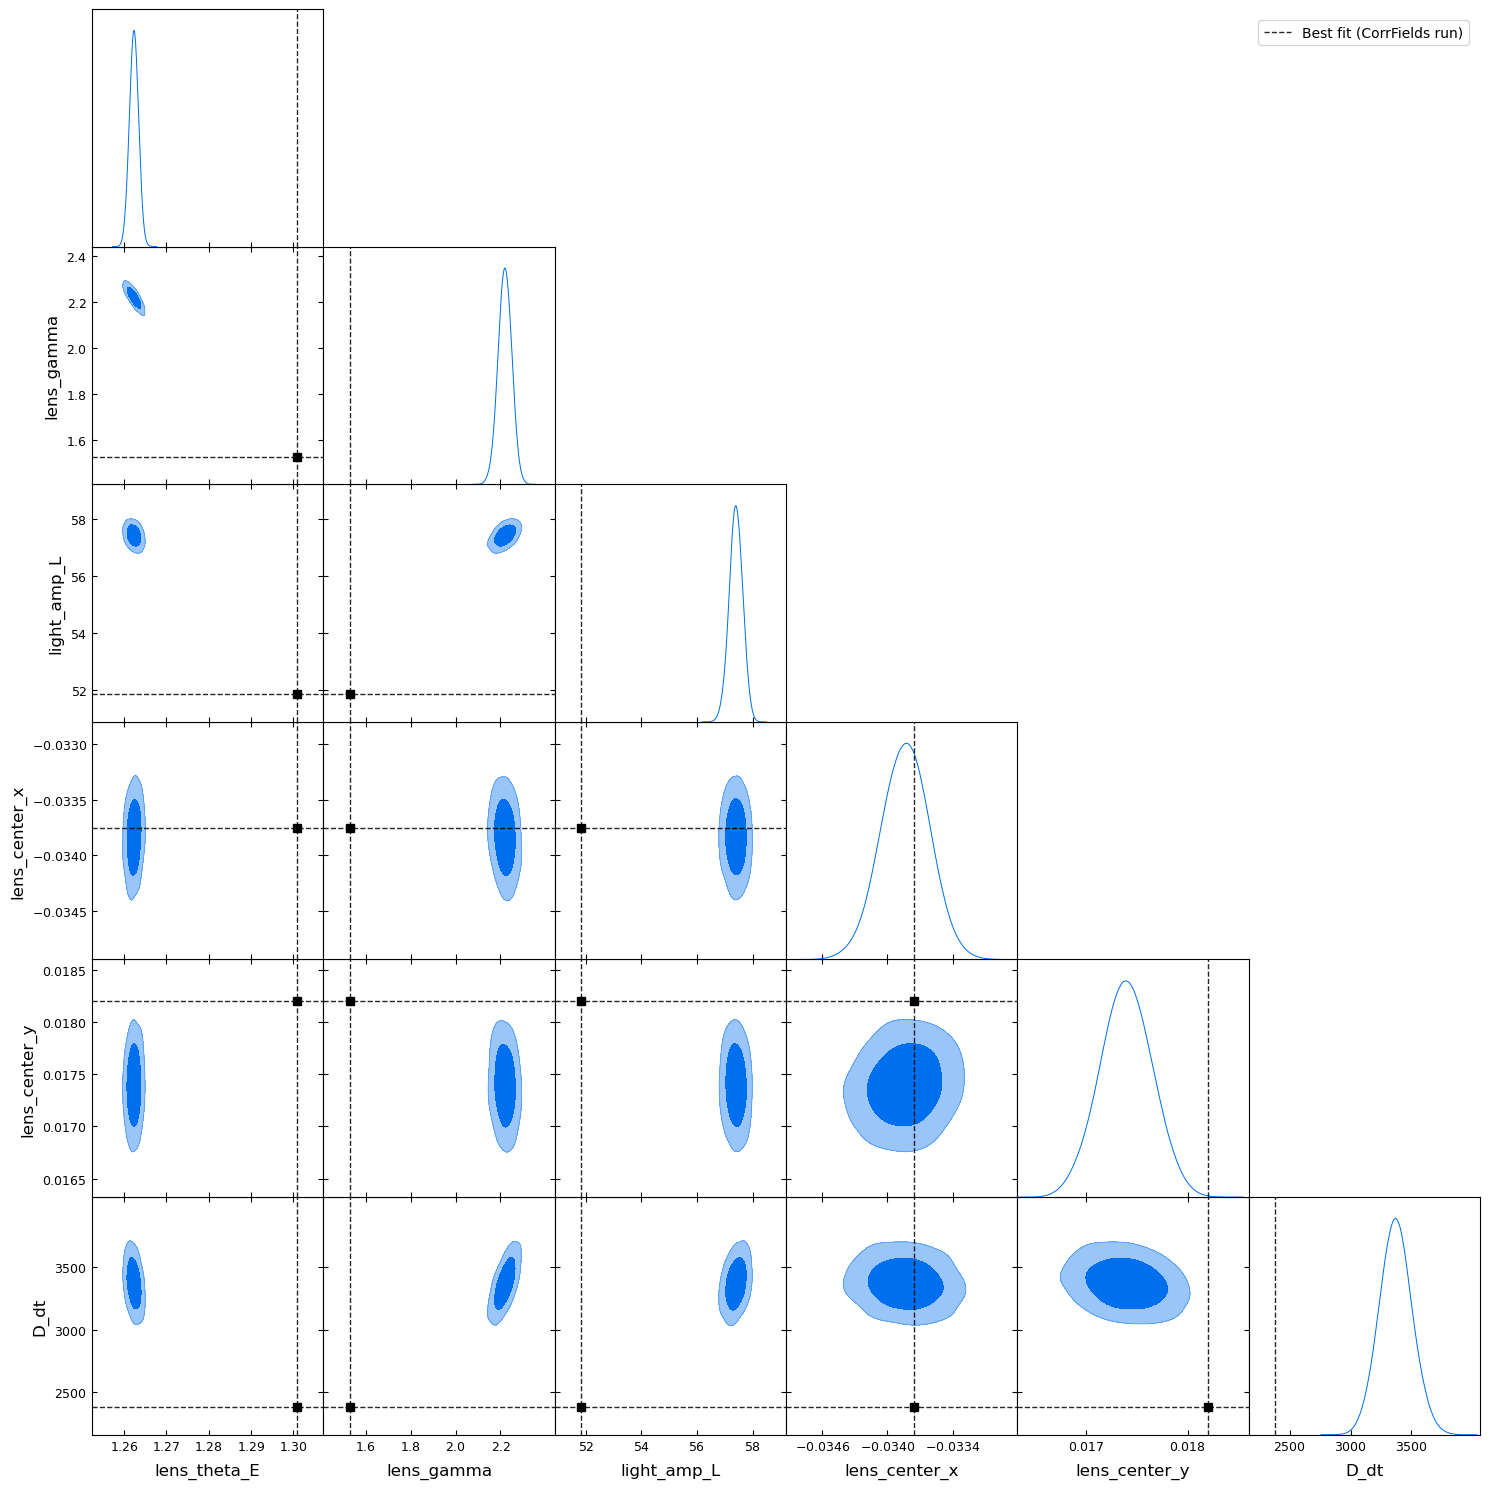

In [69]:
# Select columns for the requested parameters
indices = [param_names.index(p) for p in PARAMS_TO_PLOT]
plot_samples = samples[:, indices]

# Build marker list
markers = [lookup_bestfit(p, best_params) for p in PARAMS_TO_PLOT]

# Compute axis ranges that include both posterior samples and best-fit markers
param_ranges = {}
for i, p in enumerate(PARAMS_TO_PLOT):
    col = plot_samples[:, i]
    lo, hi = col.min(), col.max()
    bf = markers[i]
    if bf is not None:
        lo = min(lo, bf)
        hi = max(hi, bf)
    margin = 0.15 * (hi - lo)
    param_ranges[p] = (lo - margin, hi + margin)

# Build GetDist corner plot
mc_samples = MCSamples(
    samples=plot_samples,
    names=PARAMS_TO_PLOT,
    settings={"smooth_scale_1D": 0.5, "smooth_scale_2D": 0.5},
)

g = gd_plots.get_subplot_plotter(subplot_size=2.5)
g.triangle_plot(
    mc_samples,
    params=PARAMS_TO_PLOT,
    filled=True,
)

# Overlay best-fit markers
import matplotlib.lines as mlines

MARKER_COLOR = "black"
MARKER_STYLE = dict(color=MARKER_COLOR, ls="--", lw=1, alpha=0.85, zorder=10)
POINT_STYLE = dict(
    color=MARKER_COLOR, marker="s"
)

n = len(PARAMS_TO_PLOT)
for i in range(n):
    for j in range(i + 1):
        ax = g.subplots[i][j]
        if ax is None:
            continue
        bfx = markers[j]
        if i == j:
            # Diagonal: vertical line at best-fit value
            if bfx is not None:
                ax.axvline(bfx, **MARKER_STYLE)
        else:
            # Off-diagonal: crosshairs + star at best-fit point
            bfy = markers[i]
            if bfx is not None:
                ax.axvline(bfx, **MARKER_STYLE)
            if bfy is not None:
                ax.axhline(bfy, **MARKER_STYLE)
            if bfx is not None and bfy is not None:
                ax.plot(bfx, bfy, **POINT_STYLE)

# Zoom out axes to include best-fit markers
for i in range(n):
    for j in range(i + 1):
        ax = g.subplots[i][j]
        if ax is None:
            continue
        ax.set_xlim(param_ranges[PARAMS_TO_PLOT[j]])
        if i != j:
            ax.set_ylim(param_ranges[PARAMS_TO_PLOT[i]])

# Legend in the upper-right empty region of the triangle plot
legend_handles = [
    mlines.Line2D([], [], **MARKER_STYLE, label="Best fit"),
    mlines.Line2D(
        [], [], linestyle="None", label="Best fit",
        **{k: v for k, v in POINT_STYLE.items() if k != "zorder"},
    ),
]
g.fig.legend(
    handles=legend_handles, labels=["Best fit (CorrFields run)"],
    loc="upper right", frameon=True, fontsize=10,
    borderaxespad=1.5,
)

g.fig.tight_layout()